# Sequence-aware recommender system

In [1]:
import numpy as np
import warnings
import pandas as pd
from spmf import Spmf
from gensim.models import Word2Vec
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.utils import np_utils
from keras.regularizers import l2
from matplotlib import pyplot as plt
import ipywidgets as widgets
from IPython.display import display

In [2]:
warnings.filterwarnings('ignore')
columns = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 
                'UnitPrice', 'CustomerID', 'Country']
data = pd.read_csv('OnlineRetail.csv', sep=',', names=columns, engine='python')
data = data.drop(data.index[[0]])

# remove missing values
data = data[(data.Description.notnull()) & (data.Description != 'mailto') & (data.Description != 'mailout') 
            & (data.Quantity.astype(int) > 0)]
# transform column to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
# reset row index
data = data.reset_index(drop=True)

data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


## Transform transactions into lists of items

In [3]:
# filter transactions to get only transactions from the past month
max_date = data['InvoiceDate'].max()
filtered_data = data[(data.InvoiceDate <= max_date) & (data.InvoiceDate >= (max_date - pd.DateOffset(months=1)))]
transactions_array = []
transactions = filtered_data.groupby(['InvoiceNo'], as_index=False)['StockCode'].apply(list)
for i in range(0, len(transactions)):
    vals = ' '.join(transactions.values[i])
    transactions_array.append(vals)

transactions_array[:5]

['23544 21790 21791 22619',
 '23318 21136 23319 22809 22810 22739 22732 22141 22144 22142 23313 22910 23264 23265 23266 20668 21803 35471D 22952 23267 23101 23350 23351 23349 23352',
 '21888 22992 22561 23494',
 '47566 22693 22523 22522 21878 22568 22621 22865 22867 22652 23198 84987 84991 22938 23197',
 '22426 22962 22963 22227 22139 23147 16008 84347 82486 84510A 22753 22757 21380 15056BL 15056N 23031 23146 22411']

## Method for getting recommendations from product's associations

In [4]:
def recommend(recent_products, associations):
    recommended = dict()
    for p in recent_products:
        for i in range(0, len(associations.pattern)):
            if((p in associations.pattern.values[i]) and
                    (associations.pattern.values[i].index(p) != (len(associations.pattern.values[i]) - 1))):
                ind = associations.pattern.values[i].index(p)
                if p not in recommended:
                    recommended[p] = []
                recommended[p].append([associations.pattern.values[i][ind + 1:], 
                                       associations.sup.values[i]])

    return recommended

## Method for printing recommendations

In [5]:
def print_recommendations(recommended, products_dict, n):
    for r in recommended:
        print("Frequently bought with " + str(products_dict[r][0]) + " :\n")
        supports = dict()
        for p in recommended[r]:
            supports[tuple(p[0])] = p[1]
        sorted_supports = sorted(supports.items(), key=lambda x: x[1], reverse=True)

        if n > len(supports):
            m = len(supports)
        else:
            m = n
        
        for i in range(0, m):
            for y in sorted_supports[i][0]:
                print(str(products_dict[y][0]) + '\n')

## Using GSP algorithm to find associations between products

In [6]:
result_GSP = Spmf("GSP", input_direct=transactions_array, input_type="text", arguments=[0.02],
                  output_filename='GSP_output.txt',
                  spmf_bin_location_dir='D:/Kristina/Documents/Master/BI/MLRecommenderSystem')
result_GSP.run()
df_GSP = result_GSP.to_pandas_dataframe(pickle=True)
df_GSP = df_GSP[df_GSP.pattern.str.len() > 1]
df_GSP.head()

>/D:/Kristina/Documents/Master/BI/MLRecommenderSystem/spmf.jar
Converting TEXT to SPMF format.
Conversion completed.
=============  Algorithm - STATISTICS =============
 Total time ~ 111316 ms
 Frequent sequences count : 484
 Max memory (mb):190.91753387451172

Post-processing to show result in terms of string values.
Post-processing completed.



,pattern,sup
431,"[21790, 21791]",60
432,"[22141, 22144]",77
433,"[22142, 22144]",60
434,"[22086, 22144]",63
435,"[22910, 22952]",62


## Recommending similar products to user based on his latest interactions

In [7]:
session = ['85123A', '22835', '22086', '22910', '22577']
recent_products = session[-3:]

# create product-ID and product-description dictionary
products_dict = filtered_data.groupby('StockCode')['Description'].apply(list).to_dict()

# get itemsets that contain products from current session
filtered_GSP = df_GSP[df_GSP.pattern.map(lambda x: np.isin(x, recent_products).any())]

recommended = recommend(recent_products, filtered_GSP)

filtered_GSP.head()

,pattern,sup
434,"[22086, 22144]",63
435,"[22910, 22952]",62
436,"[22910, 23084]",79
437,"[22910, 22086]",80
438,"[22086, 22910]",142


In [8]:
print_recommendations(recommended, products_dict, 3)

Frequently bought with PAPER CHAIN KIT 50'S CHRISTMAS  :

PAPER CHAIN KIT VINTAGE CHRISTMAS

RABBIT NIGHT LIGHT

GARDENERS KNEELING PAD KEEP CALM 

Frequently bought with PAPER CHAIN KIT VINTAGE CHRISTMAS :

PAPER CHAIN KIT 50'S CHRISTMAS 

RABBIT NIGHT LIGHT

GARDENERS KNEELING PAD KEEP CALM 

Frequently bought with WOODEN HEART CHRISTMAS SCANDINAVIAN :

WOODEN STAR CHRISTMAS SCANDINAVIAN

WOODEN TREE CHRISTMAS SCANDINAVIAN



## Using PrefixSpan algorithm to find associations between products

In [9]:
result_PrefixSpan = Spmf("PrefixSpan", input_direct=transactions_array, input_type="text", arguments=[0.02],
                         output_filename='PS_output.txt',
                         spmf_bin_location_dir='D:/Kristina/Documents/Master/BI/MLRecommenderSystem')
result_PrefixSpan.run()
df_PrefixSpan = result_PrefixSpan.to_pandas_dataframe(pickle=True)
df_PrefixSpan = df_PrefixSpan[df_PrefixSpan.pattern.str.len() > 1]
df_PrefixSpan.head()

>/D:/Kristina/Documents/Master/BI/MLRecommenderSystem/spmf.jar
Converting TEXT to SPMF format.
Conversion completed.
=============  PREFIXSPAN 0.99-2016 - STATISTICS =============
 Total time ~ 153 ms
 Frequent sequences count : 484
 Max memory (mb) : 70.19873046875
 minsup = 59 sequences.
 Pattern count : 484

Post-processing to show result in terms of string values.
Post-processing completed.



,pattern,sup
1,"[21790, 21791]",60
10,"[22141, 22144]",77
13,"[22142, 22144]",60
16,"[22910, 22952]",62
17,"[22910, 23084]",79


In [10]:
# get itemsets that contain products from current session
filtered_PrefixSpan = df_PrefixSpan[df_PrefixSpan.pattern.map(lambda x: np.isin(x, recent_products).any())]

recommended = recommend(recent_products, filtered_PrefixSpan)

filtered_PrefixSpan.head()

,pattern,sup
16,"[22910, 22952]",62
17,"[22910, 23084]",79
18,"[22910, 22086]",80
19,"[22910, 23301]",63
59,"[22578, 22577]",67


In [11]:
print_recommendations(recommended, products_dict, 3)

Frequently bought with PAPER CHAIN KIT 50'S CHRISTMAS  :

PAPER CHAIN KIT VINTAGE CHRISTMAS

RABBIT NIGHT LIGHT

GARDENERS KNEELING PAD KEEP CALM 

Frequently bought with PAPER CHAIN KIT VINTAGE CHRISTMAS :

PAPER CHAIN KIT 50'S CHRISTMAS 

RABBIT NIGHT LIGHT

GARDENERS KNEELING PAD KEEP CALM 

Frequently bought with WOODEN HEART CHRISTMAS SCANDINAVIAN :

WOODEN STAR CHRISTMAS SCANDINAVIAN

WOODEN TREE CHRISTMAS SCANDINAVIAN



## Using Prod2Vec for distributed product representation

In [12]:
transactions_array = []
transactions = data.groupby(['InvoiceNo'], as_index=False)['StockCode'].apply(list)
for i in range(0, len(transactions)):
    transactions_array.append(transactions.values[i])
 
transactions_array[:5]

[['85123A', '71053', '84406B', '84029G', '84029E', '22752', '21730'],
 ['22633', '22632'],
 ['84879',
  '22745',
  '22748',
  '22749',
  '22310',
  '84969',
  '22623',
  '22622',
  '21754',
  '21755',
  '21777',
  '48187'],
 ['22960', '22913', '22912', '22914'],
 ['21756']]

In [13]:
# train word2vec model
model = Word2Vec(window=10, sg=1, hs=1, alpha=0.01, min_alpha=0.0001)

model.build_vocab(transactions_array)

model.train(transactions_array, total_examples=model.corpus_count, epochs=30)

products = data[["StockCode", "Description"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# create product-ID and product-description dictionary
products_dict = data.groupby('StockCode')['Description'].apply(list).to_dict()
product_names_dict = data.groupby('Description')['StockCode'].apply(list).to_dict()

## Method for finding similar products given an input product vector

In [14]:
def similar_products(v, n, session):   
    # extract most similar products for the input vector
    products = model.similar_by_vector(v, topn=n)
    
    # extract name and similarity score of the similar products
    most_similar_products = []
    for j in products:
        if j[0] not in session:
            pair = (products_dict[j[0]][0], j[1])
            most_similar_products.append(pair)
        
    return most_similar_products     

## Method for aggregating products from session into single vector

In [15]:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        product_vec.append(model[i])
        
    return np.mean(product_vec, axis=0)

## Recommending similar products based on products in current session

In [16]:
print("Similar products:\n")
recommended = similar_products(aggregate_vectors(recent_products), 8, session)
for p in recommended:
    print(str(p[0]) + '\n')

Similar products:

SET OF 20 VINTAGE CHRISTMAS NAPKINS

WOODEN STAR CHRISTMAS SCANDINAVIAN

WOODEN TREE CHRISTMAS SCANDINAVIAN

METAL MERRY CHRISTMAS WREATH

ADVENT CALENDAR GINGHAM SACK



## Using recurrent neural network to predict products for session continuation

## Many-to-one model

In [17]:
# filter data
n = data.groupby('StockCode').count()[['InvoiceNo']]
purchases = dict()
for i in n.index:
    purchases[i] = n['InvoiceNo'].loc[i]

sorted_purchases = sorted(purchases.items(), key=lambda x: x[1])
least_purchased = []
most_purchased = []
for i in range(1500):
    least_purchased.append(sorted_purchases[i][0])
    most_purchased.append(sorted_purchases[-i][0])

filtered_products = data[~data.StockCode.isin(least_purchased)]
filtered_products.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [18]:
filtered_data = filtered_products[(filtered_products.InvoiceDate <= max_date) 
                               & (filtered_products.InvoiceDate >= (max_date - pd.DateOffset(months=3)))]
transactions_array = []
transactions = filtered_data.groupby(['InvoiceNo'], as_index=False)['StockCode'].apply(list)
for i in range(0, len(transactions)):
    transactions_array.append(transactions.values[i])

products = filtered_data.StockCode.unique()
print("Number of unique products: " + str(len(products)))
products_to_int = dict((p, i) for i, p in enumerate(products, start=1))
int_to_products = dict((i, p) for i, p in enumerate(products, start=1))

seq_length = 3
dataX = []
dataY = []

for i in range(0, len(transactions_array)):
    for j in range(0, len(transactions_array[i]) - seq_length):
        seq_in = transactions_array[i][j:j + seq_length]
        seq_out = transactions_array[i][j + seq_length]
        dataX.append([products_to_int[prod] for prod in seq_in])
        dataY.append(products_to_int[seq_out])

print("Total number of sequences: " + str(len(dataX)))

# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (len(dataX), seq_length, 1))

# make output categorical
y = np_utils.to_categorical(dataY)

Number of unique products: 2311
Total number of sequences: 179186


In [19]:
lstm_model = Sequential()
lstm_model.add(Embedding(len(products) + 1, 30, input_length=seq_length))
lstm_model.add(LSTM(100, kernel_regularizer=l2(0.0001), recurrent_regularizer=l2(0.0001),
                    return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50, kernel_regularizer=l2(0.0001), recurrent_regularizer=l2(0.0001)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(y.shape[1], activation='softmax'))
opt = Adam(learning_rate=0.001)
lstm_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
print(lstm_model.summary())
h = lstm_model.fit(X, y, epochs=50, batch_size=100, validation_split=0.2, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 3, 30)             69360     
_________________________________________________________________
lstm (LSTM)                  (None, 3, 100)            52400     
_________________________________________________________________
dropout (Dropout)            (None, 3, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 2312)              117912    
Total params: 269,872
Trainable params: 269,872
Non-trainable params: 0
__________________________________________________

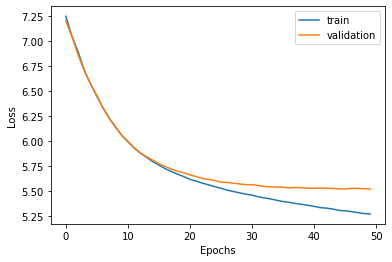

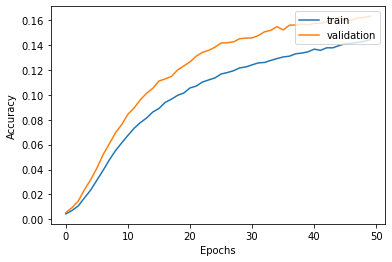

In [20]:
plt.plot(h.history['loss'], label='Train loss')
plt.plot(h.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
plt.plot(h.history['accuracy'], label='Train accuracy')
plt.plot(h.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Predicting next product(s) in session

In [21]:
session_enumerated = []
session_enumerated.append([products_to_int[prod] for prod in recent_products])
results = []

for i in range(3):
    x = np.reshape(session_enumerated, (1, seq_length, 1))
    prediction = lstm_model.predict(x, verbose=0)
    index = np.argmax(prediction)
    results.append(int_to_products[index])
    session_enumerated[0].append(index)
    session_enumerated[0] = session_enumerated[0][1:len(session_enumerated[0])]

print("Recommended products: \n")
for res in results:
    print(products_dict[res][0])

Recommended products: 

WOODEN STAR CHRISTMAS SCANDINAVIAN
WOODEN TREE CHRISTMAS SCANDINAVIAN
ADVENT CALENDAR GINGHAM SACK


## UI logic

In [22]:
def show_recommendations(recommended, n):
    if len(lbl_frequently_bought) > 0:
        lbl_frequently_bought[-1].close()
        lbl_frequently_bought.remove(lbl_frequently_bought[-1])
        grid_box_frequently_bought[-1].close()
        grid_box_frequently_bought.remove(grid_box_frequently_bought[-1])
    
    for r in recommended:
        lbl_bought_together = widgets.Label(value="Frequently bought with " + str(products_dict[r][0]))
        lbl_frequently_bought.append(lbl_bought_together)
        display(lbl_bought_together)
        supports = dict()
        for p in recommended[r]:
            supports[tuple(p[0])] = p[1]
        sorted_supports = sorted(supports.items(), key=lambda x: x[1], reverse=True)

        if n > len(supports):
            m = len(supports)
        else:
            m = n
        
        boxes = []
        for i in range(0, m):
            for y in sorted_supports[i][0]:
                lbl_name = widgets.Label(value=products_dict[y][0])
                btn_view = widgets.Button(description='View', disabled=False, button_style='info', tooltip='')
                btn_add_to_cart = widgets.Button(description='Add to cart', disabled=False, button_style='info', tooltip='')
                v_box = widgets.VBox([lbl_name, widgets.Box([btn_view, btn_add_to_cart])])
                btn_view.parent = v_box
                btn_add_to_cart.parent = v_box
                btn_view.on_click(on_btn_view_click)
                btn_add_to_cart.on_click(on_btn_cart_click)
                boxes.append(v_box)
        
        grid_box_bought_together = widgets.GridBox(boxes, layout=widgets.Layout(grid_template_columns="repeat(3, 350px)"))
        grid_box_frequently_bought.append(grid_box_bought_together)
        display(grid_box_bought_together)

In [23]:
def get_and_show_recommendations(interactions):
    recommendations_PrefixSpan = recommend(interactions, filtered_PrefixSpan)
    show_recommendations(recommendations_PrefixSpan, 3)

In [24]:
def show_similar_products(interactions):
    if len(interactions) > 5:
        interactions = interactions[-5:]
    
    recommended = similar_products(aggregate_vectors(interactions), 10, interactions)
    
    if len(lbl_similar_products) > 0:
        lbl_similar_products[-1].close()
        lbl_similar_products.remove(lbl_similar_products[-1])
        grid_box_similar_products[-1].close()
        grid_box_similar_products.remove(grid_box_similar_products[-1])
    
    lbl_similar = widgets.Label(value="Similar products:")
    lbl_similar_products.append(lbl_similar)
    display(lbl_similar)
    
    boxes = []
    for r in recommended[:6]:
        lbl_name = widgets.Label(value=r[0])
        btn_view = widgets.Button(description='View', disabled=False, button_style='info', tooltip='')
        btn_add_to_cart = widgets.Button(description='Add to cart', disabled=False, button_style='info', tooltip='')
        v_box = widgets.VBox([lbl_name, widgets.Box([btn_view, btn_add_to_cart])])
        btn_view.parent = v_box
        btn_add_to_cart.parent = v_box
        btn_view.on_click(on_btn_view_click)
        btn_add_to_cart.on_click(on_btn_cart_click)
        boxes.append(v_box)
        
    grid_box_similar = widgets.GridBox(boxes, layout=widgets.Layout(grid_template_columns="repeat(3, 350px)"))
    grid_box_similar_products.append(grid_box_similar)
    display(grid_box_similar)

In [25]:
def show_recommended_products(interactions):
    if len(lbl_recommended_products) > 0:
        lbl_recommended_products[-1].close()
        lbl_recommended_products.remove(lbl_recommended_products[-1])
        grid_box_recommended_products[-1].close()
        grid_box_recommended_products.remove(grid_box_recommended_products[-1])
    
    lbl_recommended = widgets.Label(value="Recommended products:")
    lbl_recommended_products.append(lbl_recommended)
    display(lbl_recommended)
    
    interactions_enumerated = []
    interactions_enumerated.append([products_to_int[prod] for prod in interactions])
    results = []
    
    for i in range(5):
        x = np.reshape(interactions_enumerated, (1, seq_length, 1))
        prediction = lstm_model.predict(x, verbose=0)
        index = np.argmax(prediction)
        if (index not in interactions_enumerated[0]) and (int_to_products[index] not in interactions)\
                and (int_to_products[index] not in results):
            results.append(int_to_products[index])
            interactions_enumerated[0].append(index)
            interactions_enumerated[0] = interactions_enumerated[0][1:len(interactions_enumerated[0])]
    
    boxes = []
    for r in results:
        lbl_name = widgets.Label(value=products_dict[r][0])
        btn_view = widgets.Button(description='View', disabled=False, button_style='info', tooltip='')
        btn_add_to_cart = widgets.Button(description='Add to cart', disabled=False, button_style='info', tooltip='')
        v_box = widgets.VBox([lbl_name, widgets.Box([btn_view, btn_add_to_cart])])
        btn_view.parent = v_box
        btn_add_to_cart.parent = v_box
        btn_view.on_click(on_btn_view_click)
        btn_add_to_cart.on_click(on_btn_cart_click)
        boxes.append(v_box)
        
    grid_box_recommended = widgets.GridBox(boxes, layout=widgets.Layout(grid_template_columns="repeat(3, 350px)"))
    grid_box_recommended_products.append(grid_box_recommended)
    display(grid_box_recommended)

In [26]:
def on_btn_cart_click(b):
    n = int(btn_cart.description)
    n += 1
    btn_cart.description = str(n)
    if ((len(interacted_with) == 0) or 
            ((len(interacted_with) > 0) and (interacted_with[-1] != product_names_dict[b.parent.children[0].value][0]))):
        interacted_with.append(product_names_dict[b.parent.children[0].value][0])
        get_and_show_recommendations(interacted_with[-1:])
        show_similar_products(interacted_with)
    
        if len(interacted_with) >= 3:
            show_recommended_products(interacted_with[-3:])

In [27]:
def on_btn_view_click(b):
    if ((len(interacted_with) == 0) or 
            ((len(interacted_with) > 0) and (interacted_with[-1] != product_names_dict[b.parent.children[0].value][0]))):
        interacted_with.append(product_names_dict[b.parent.children[0].value][0])
        get_and_show_recommendations(interacted_with[-1:])
        show_similar_products(interacted_with)
    
        if len(interacted_with) >= 3:
            show_recommended_products(interacted_with[-3:])

In [29]:
btn_cart = widgets.Button(
    description='0',
    disabled=False,
    button_style='info',
    tooltip='',
    icon='shopping-cart'
)
display(btn_cart)

boxes = []
interacted_with = []
prods_to_show = []
for p in recent_products:
    prods_to_show.append(p)
for p in most_purchased[:20]:
    if p not in prods_to_show:
        prods_to_show.append(p)

for p in prods_to_show:
    btn_view = widgets.Button(description='View', disabled=False, button_style='info', tooltip='')
    btn_add_to_cart = widgets.Button(description='Add to cart', disabled=False, button_style='info', tooltip='')
    lbl_name = widgets.Label(products_dict[p][0])
    v_box = widgets.VBox([lbl_name, widgets.Box([btn_view, btn_add_to_cart])])
    btn_view.parent = v_box
    btn_add_to_cart.parent = v_box
    btn_view.on_click(on_btn_view_click)
    btn_add_to_cart.on_click(on_btn_cart_click)
    boxes.append(v_box)

grid_box = widgets.GridBox(boxes, layout=widgets.Layout(grid_template_columns="repeat(2, 400px)"))
display(grid_box)

lbl_frequently_bought = []
grid_box_frequently_bought = []
lbl_similar_products = []
grid_box_similar_products = []
lbl_recommended_products = []
grid_box_recommended_products = []

Button(button_style='info', description='0', icon='shopping-cart', style=ButtonStyle())

GridBox(children=(VBox(children=(Label(value="PAPER CHAIN KIT 50'S CHRISTMAS "), Box(children=(Button(button_s…